In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: True
GPU name: NVIDIA GeForce RTX 4060


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}


In [6]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

In [10]:
train_df = create_df(r"D:\Download\Oily-Dry-Skin-Types\train")
val_df = create_df(r"D:\Download\Oily-Dry-Skin-Types\valid")
test_df = create_df(r"D:\Download\Oily-Dry-Skin-Types\test")

In [11]:
train_df = pd.concat([train_df, val_df, test_df])

In [12]:
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [19]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))
        
        return img, label

In [20]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [21]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [22]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [23]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [24]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [26]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [27]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    
    diff = 0
    total = 0
    acc = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    
    diff = 0
    total = 0
    acc = 0
    
    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                
            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
            
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    scheduler.step()
    
    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

Epochs 1 train loss 0.04497671316465372 acc 0.46886156287187625 val loss 0.052550123229859365 acc 0.37142857142857144
Epochs 2 train loss 0.021229420044931897 acc 0.7207457358191194 val loss 0.03873026862977043 acc 0.5301587301587302
Epochs 3 train loss 0.013668202989775715 acc 0.828639428798096 val loss 0.040986863582853285 acc 0.5873015873015873
Epochs 4 train loss 0.009270160225874277 acc 0.8940896469654899 val loss 0.03488991374061221 acc 0.6317460317460317
Epochs 5 train loss 0.006733679156107639 acc 0.9238397461324871 val loss 0.03051076749014476 acc 0.6857142857142857
Epochs 6 train loss 0.004662375754570734 acc 0.9488298294327647 val loss 0.029161782491774785 acc 0.7142857142857143
Epochs 7 train loss 0.003328811832788987 acc 0.9658865529551766 val loss 0.024376089799971808 acc 0.7587301587301587
Epochs 8 train loss 0.0015223486369674473 acc 0.9849266164220547 val loss 0.023000066526352413 acc 0.8031746031746032
Epochs 9 train loss 0.0022744979947297073 acc 0.9754065846886156 v

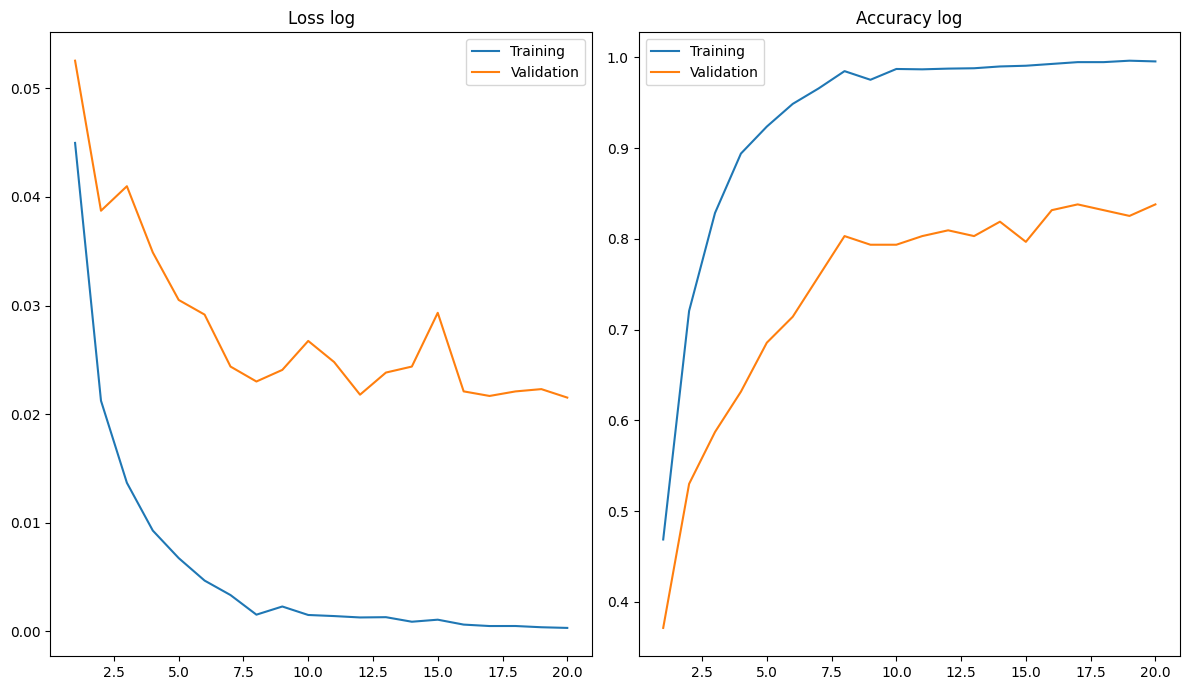

In [28]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [29]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        
        return out.argmax(1).item()

In [30]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

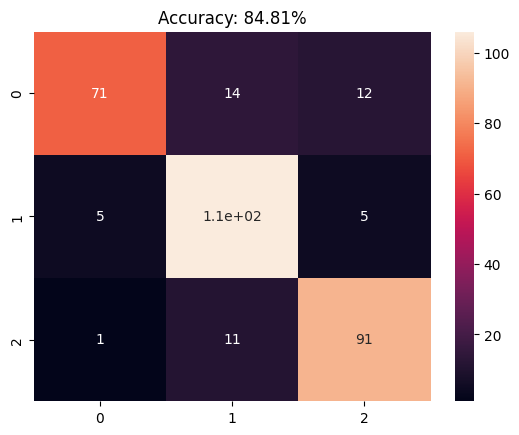

In [31]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [32]:
print(report)

              precision    recall  f1-score   support

           0       0.92      0.73      0.82        97
           1       0.81      0.91      0.86       116
           2       0.84      0.88      0.86       103

    accuracy                           0.85       316
   macro avg       0.86      0.84      0.85       316
weighted avg       0.85      0.85      0.85       316



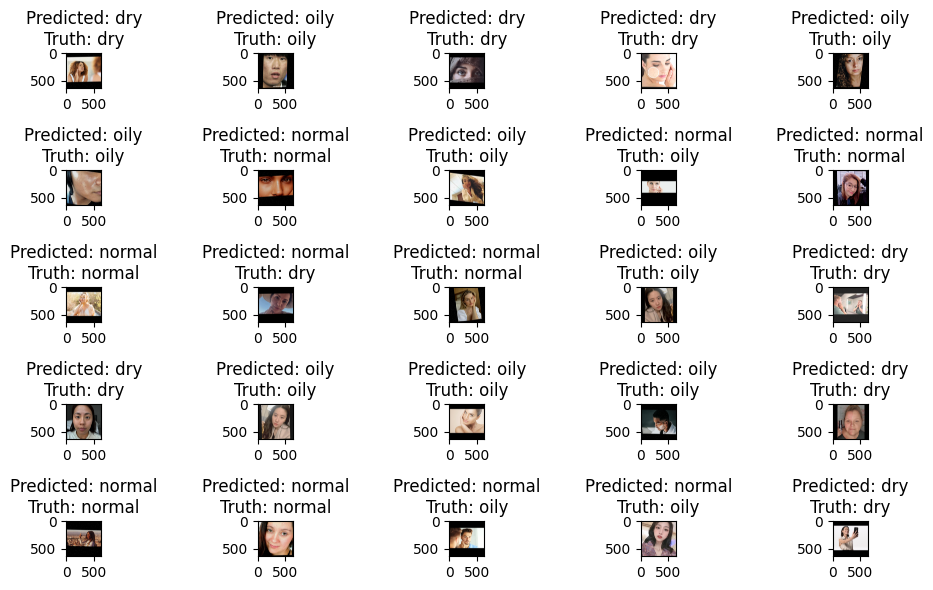

In [33]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1
        
plt.tight_layout()
plt.show()